<a href="http://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07B%20-%20Text%20Classification%20Deep%20Learning%20CNN%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP: Text Classification

When it comes to text data, sentiment analysis is one of the most widely performed analysis on it. Sentiment Analysis has been through tremendous improvements from the days of classic methods to recent times where in the state of the art models utilize deep learning to improve the performance.

In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.2 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
import random

# fix random seed for reproducibility
seed = 42

np.random.seed(seed)        # NumPy randomness
tf.random.set_seed(seed)    # TensorFlow randomness
random.seed(seed)           # Python's builtin randomness


## 1. Dataset and Data Preparation

### 1.1. Load Movie Review Dataset

* ### IMDB Dataset of 50K Movie Reviews https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

IMDB dataset having 50K movie reviews for natural language processing or Text analytics. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark.

In [ ]:
dataset = pd.read_csv(r'https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
# take a peek at the data
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### 1.2. Data Analysis

In [ ]:
### Print full reviews
for i in range(3):
    print(f"\nReview {i} ({dataset.loc[i, 'sentiment']}):\n")
    print(dataset.loc[i, "review"])


Review 0 (positive):

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the

In [ ]:
### Inspect class distribution
dataset["sentiment"].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [ ]:
### Compute review lenght (word-based lenght)
dataset["review_length"] = dataset["review"].apply(lambda x: len(x.split()))

print("Average review length:", dataset["review_length"].mean())
print("Maximum review length:", dataset["review_length"].max())
print("Minimum review length:", dataset["review_length"].min())

Average review length: 231.15694
Maximum review length: 2470
Minimum review length: 4


### 1.3. Dataset splitting

In [ ]:
# build train and test datasets
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

### 1.4. Data Preprocessing

#### a) Text Wrangling & Normalization

In [ ]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text): # ensures text is standardized for easier tokenization
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc) # expand contractions
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    norm_docs.append(doc)

  return norm_docs

In [ ]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 15000/15000 [00:09<00:00, 1526.79it/s]

CPU times: user 36.2 s, sys: 534 ms, total: 36.7 s
Wall time: 46.1 s


In [ ]:
norm_train_reviews[2]

'i thought this was a wonderful way to spend time on a too hot summer weekend sitting in the air conditioned theater and watching a light hearted comedy the plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer while some may be disappointed when they realize this is not match point 2 risk addiction i thought it was proof that woody allen is still fully in control of the style many of us have grown to love this was the most i would laughed at one of woody s comedies in years dare i say a decade while i have never been impressed with scarlet johanson in this she managed to tone down her sexy image and jumped right into a average but spirited young woman this may not be the crown jewel of his career but it was wittier than devil wears prada and more interesting than superman a great comedy to go see with friends'

#### b) Tokenization

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [ ]:
t = Tokenizer(oov_token='<UNK>') # word not seen during training will be replaced with the token <UNK>
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews) # Builds the word index from training corpus

# assign the integer 0 to the special <PAD> token
t.word_index['<PAD>'] = 0

See the first 10 mappings

In [ ]:
n_items = 10
i_count = 0

for k, v in t.word_index.items():
  if i_count < n_items:
    print(k,v)
    i_count = i_count +1
  else:
      break

<UNK> 1
the 2
and 3
a 4
of 5
is 6
to 7
it 8
in 9
i 10


In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

# Finds the tuple with the largest index value (least frequent word, because Keras assigns smaller IDs to frequent words)

(('whoah', 89398), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews) # converts each review into a sequence of integers using the vocabulary learned by the Tokenizer

In [ ]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=89399
Number of Documents=35000


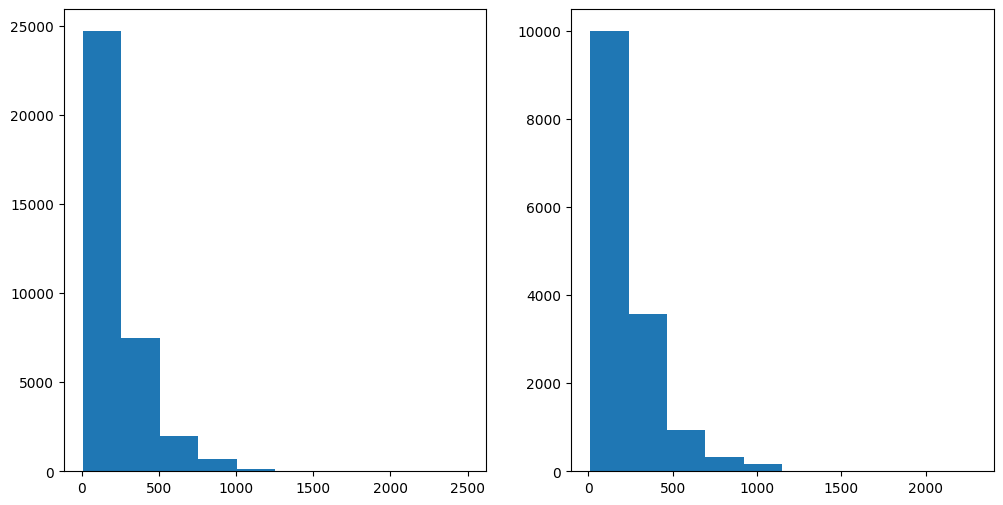

In [ ]:
# visualize distribution of review lengths

import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

#### c) Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [ ]:
MAX_SEQUENCE_LENGTH = 1000

In [ ]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((35000, 1000), (15000, 1000))

#### d) Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [ ]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [ ]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [ ]:
VOCAB_SIZE = len(t.word_index)

## 2. Deep Learning Models

### 2.1. Pipeline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout

def plot_training_history(history):
    """Plot train vs validation accuracy and loss."""
    plt.figure(figsize=(10, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train acc')
    plt.plot(history.history['val_accuracy'], label='Val acc')
    plt.title('Accuracy per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Val loss')
    plt.title('Loss per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, class_names=('neg','pos')):
    """Pretty confusion matrix plot."""
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([0, 1]); ax.set_xticklabels(class_names)
    ax.set_yticks([0, 1]); ax.set_yticklabels(class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

def plot_roc_pr(y_true, y_prob):
    """Plot ROC and Precision-Recall curves."""
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # PR
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.subplot(1,2,2)
    plt.plot(recall, precision)
    plt.title('Precision–Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.tight_layout()
    plt.show()

def run_binary_pipeline(
    model,
    X_train, y_train,
    X_test, y_test,
    *,
    validation_size=0.1,
    batch_size,
    epochs,
    optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=(tf.keras.metrics.BinaryAccuracy(name='accuracy'),),
    callbacks=None,
    class_weight=None,
    threshold=0.5,
    plot_curves=True,
    verbose=1,
    stratify=True,
):
    """
    Train/evaluate a binary Keras model end-to-end with visualizations.

    Parameters:
      model: a Keras model with last layer output shape (1) and sigmoid activation.
      X_train, y_train: training features and binary labels {0,1}
      X_test, y_test: test features and binary labels {0,1}
      validation_size: fraction for validation split from the training data
      optimizer, loss, metrics: compile settings
      callbacks: list of Keras callbacks (e.g., EarlyStopping)
      class_weight: dict {0: w0, 1: w1} for imbalance
      threshold: decision threshold for converting probabilities to {0,1}
      plot_curves: whether to plot ROC & PR curves
      stratify: whether to stratify the train/val split
    """
    # 1) Train/Val split
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train,
        test_size=validation_size,
        random_state=42,
        stratify=y_train if stratify else None
    )

    # 2) Compile model
    model.compile(optimizer=optimizer, loss=loss, metrics=list(metrics))

    # 3) Train
    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks or [],
        class_weight=class_weight,
        verbose=verbose
    )

    # 4) Visualize training curves
    plot_training_history(history)

    # 5) Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

    # 6) Predictions & thresholding
    y_prob = model.predict(X_test).ravel()
    y_pred = (y_prob >= float(threshold)).astype(int)

    # 7) Classification report
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

    # 8) Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion matrix:\n", cm)
    plot_confusion_matrix(cm)

    # 9) ROC & PR
    if plot_curves:
        plot_roc_pr(y_test, y_prob)

    # Return artifacts for further analysis
    return {
        'history': history,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'y_prob': y_prob,
        'y_pred': y_pred,
        'cm': cm,
        'model': model,
    }

### 2.2. Dense Neural Networks


#### a) Simple embedding + dhidden dense layer + dense output layer

When an optimizer such as Adam is instantiated, it maintains internal state variables—such as momentum and velocity—for each trainable parameter in the model. These state variables are explicitly associated with the specific weights of the model being optimized and evolve as training progresses.

Given the relatively small number of parameters and the simplicity of the model, the risk of overfitting was low. Therefore, dropout was not strictly necessary; however, it was still experimented with as a precautionary regularization measure.

In [ ]:
EMBED_SIZE = 100
EPOCHS=10
BATCH_SIZE=128

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sentiment_dense_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1000, 100)      │     8,939,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 16)             │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,941,533 (34.11 MB)

 Trainable params: 8,941,533 (34.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.5272 - loss: 0.6915 - val_accuracy: 0.5143 - val_loss: 0.6755
Epoch 2/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.6018 - loss: 0.6594 - val_accuracy: 0.6420 - val_loss: 0.5943
Epoch 3/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.7132 - loss: 0.5581 - val_accuracy: 0.8246 - val_loss: 0.4587
Epoch 4/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.7998 - loss: 0.4520 - val_accuracy: 0.8246 - val_loss: 0.4145
Epoch 5/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.8301 - loss: 0.3950 - val_accuracy: 0.8297 - val_loss: 0.3906


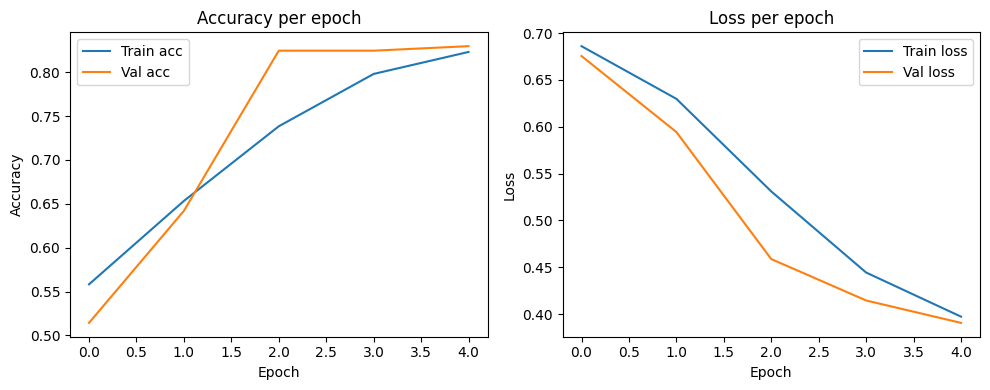

Test loss: 0.3827 | Test accuracy: 0.8312
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification report:
              precision    recall  f1-score   support

    negative       0.77      0.94      0.85      7490
    positive       0.92      0.73      0.81      7510

    accuracy                           0.83     15000
   macro avg       0.85      0.83      0.83     15000
weighted avg       0.85      0.83      0.83     15000


Confusion matrix:
 [[7009  481]
 [2051 5459]]


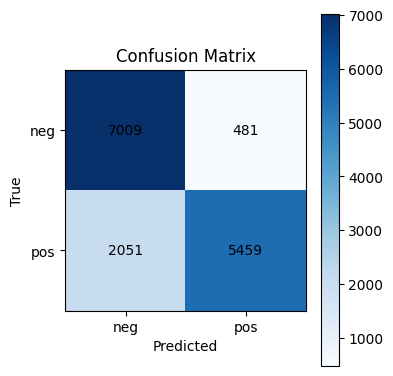

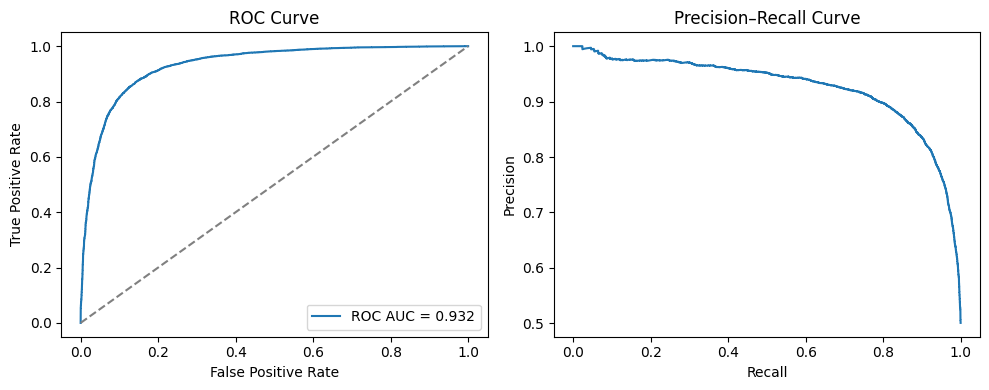

In [ ]:
K.clear_session()

model_dense = Sequential(name="sentiment_dense_model")

model_dense.add(Embedding(
    VOCAB_SIZE,
    EMBED_SIZE,
    input_shape=(MAX_SEQUENCE_LENGTH,),
    name="embedding"
))

model_dense.add(GlobalAveragePooling1D(name="avg_pool"))
model_dense.add(Dense(16, activation='relu', name="dense_hidden"))
model_dense.add(Dense(1, activation='sigmoid', name="output"))
model_dense.summary()

# Create a new optimizer instance
dense_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Define Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=2,          # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

artifacts_dense = run_binary_pipeline(
    model_dense,
    X_train, y_train, X_test, y_test,
    epochs=5,
    optimizer=dense_optimizer,
    batch_size=128,
    threshold=0.5,          # adjust later if needed
    plot_curves=True,
    callbacks=[early_stopping_callback]
)


In [ ]:
predictions_dense = (model_dense.predict(X_test) > 0.5).astype("int32")
predictions_dense = ['positive' if item == 1 else 'negative' for item in predictions_dense]
predictions_dense[:10]

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


['negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'negative',
 'positive',
 'positive']

Get insight into the model by retrieving the word embeddings learned during training. The embeddings are weights of the Embedding layer in the model. The weights matrix is of shape (vocab_size, embedding_dimension).

Obtain the weights from the model using get_layer() and get_weights(). The get_vocabulary() function provides the vocabulary to build a metadata file with one token per line

In [ ]:
weights = model_dense.get_layer('embedding').get_weights()[0]
vocab = list(t.word_index.keys())

Write the weights to disk. To use the [Embedding Projector](http://projector.tensorflow.org/), you will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [ ]:
import io
import os
import re
import shutil
import string

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()


If you are running this tutorial in Colaboratory, you can use the following snippet to download these files to your local machine (or use the file browser, View -> Table of contents -> File browser).

In [ ]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The embeddings can be visualized by uploading them to the embedding projector.

Open the [Embedding Projector](http://projector.tensorflow.org/), (this can also run in a local TensorBoard instance).

    Click on "Load data".

    Upload the two files you created above: vecs.tsv and meta.tsv.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful".


#### b) Ablation Study: Removing hidden dense layer

In [ ]:
EMBED_SIZE = 100
EPOCHS=10
BATCH_SIZE=128

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sentiment_dense_model_abl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1000, 100)      │     8,939,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,940,001 (34.10 MB)

 Trainable params: 8,940,001 (34.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.6947 - loss: 0.6924 - val_accuracy: 0.5206 - val_loss: 0.6726
Epoch 2/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.6149 - loss: 0.6532 - val_accuracy: 0.7414 - val_loss: 0.5787
Epoch 3/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.7124 - loss: 0.5682 - val_accuracy: 0.7017 - val_loss: 0.5331
Epoch 4/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.7765 - loss: 0.4883 - val_accuracy: 0.7520 - val_loss: 0.4754
Epoch 5/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.8037 - loss: 0.4319 - val_accuracy: 0.8169 - val_loss: 0.4130


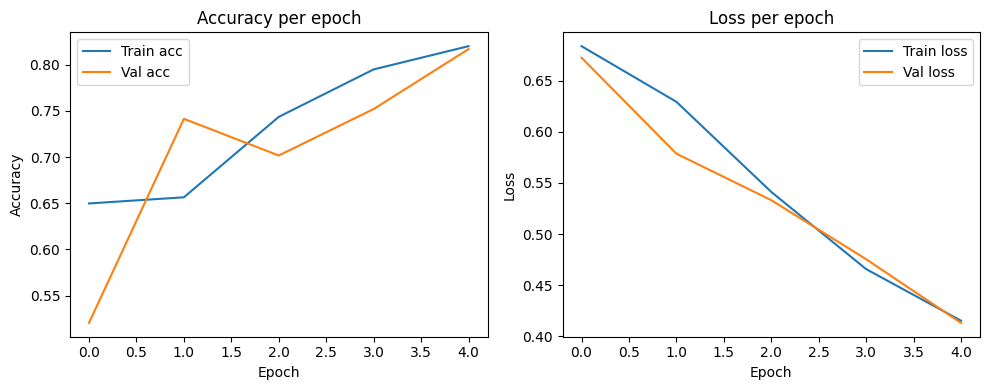

Test loss: 0.4072 | Test accuracy: 0.8196
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification report:
              precision    recall  f1-score   support

    negative       0.92      0.70      0.79      7490
    positive       0.76      0.94      0.84      7510

    accuracy                           0.82     15000
   macro avg       0.84      0.82      0.82     15000
weighted avg       0.84      0.82      0.82     15000


Confusion matrix:
 [[5210 2280]
 [ 426 7084]]


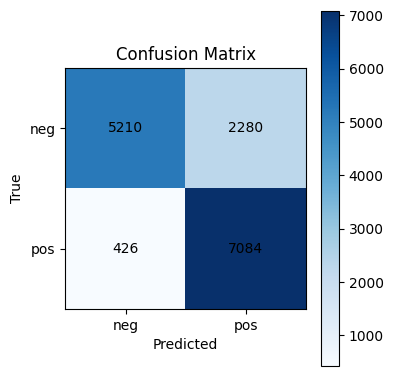

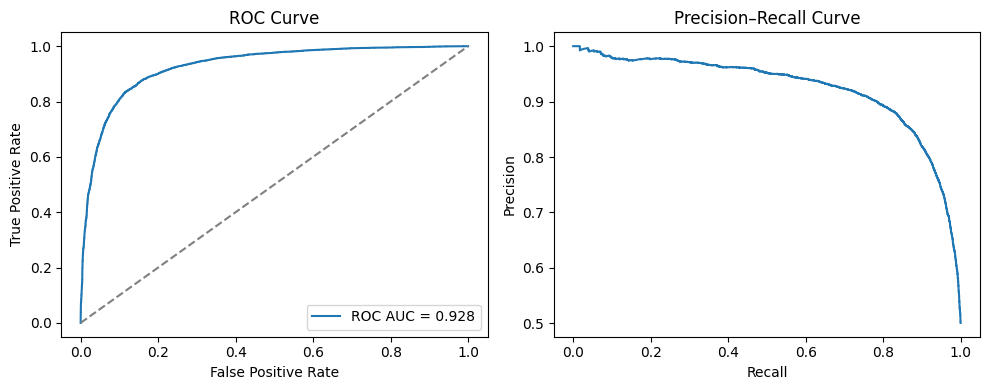

In [ ]:
K.clear_session()

model_dense_abl = Sequential(name="sentiment_dense_model_abl")

model_dense_abl.add(Embedding(
    VOCAB_SIZE,
    EMBED_SIZE,
    input_shape=(MAX_SEQUENCE_LENGTH,),
    name="embedding"
))

model_dense_abl.add(GlobalAveragePooling1D(name="avg_pool"))
model_dense_abl.add(Dense(1, activation='sigmoid', name="output"))
model_dense_abl.summary()

# Create a new optimizer instance
dense_abl_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Define Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=2,          # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

artifacts_dense_abl = run_binary_pipeline(
    model_dense_abl,
    X_train, y_train, X_test, y_test,
    epochs=5,
    optimizer=dense_abl_optimizer,
    batch_size=128,
    threshold=0.5,          # adjust later if needed
    plot_curves=True,
    callbacks=[early_stopping_callback]
)


**Compare original and ablated model**

Dense hidden weights shape: (100, 16)
Dense hidden bias shape: (16,)


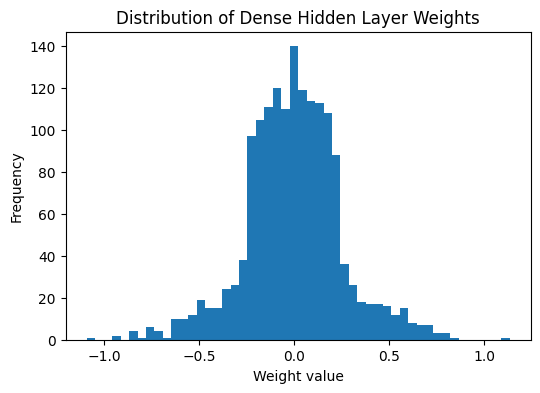

In [ ]:
### Inspect Dense Layer Weights

def inspect_dense_hidden(model):
    dense = model.get_layer("dense_hidden")
    W, b = dense.get_weights()

    print("Dense hidden weights shape:", W.shape)   # (embedding_dim, hidden_units)
    print("Dense hidden bias shape:", b.shape)

    # visualize distribution
    plt.figure(figsize=(6,4))
    plt.hist(W.flatten(), bins=50)
    plt.title("Distribution of Dense Hidden Layer Weights")
    plt.xlabel("Weight value")
    plt.ylabel("Frequency")
    plt.show()

inspect_dense_hidden(model_dense)


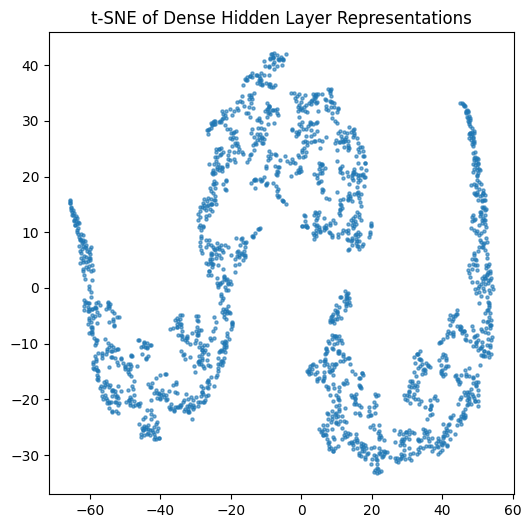

In [ ]:
### Project Hidden Layer Neuron Activations

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualize_hidden_representations(model, X, sample_size=2000):
    # Explicitly create an Input layer that matches the model's input shape
    inputs_for_submodel = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

    # Chain the relevant layers from the original model to create the sub-model
    x = model.get_layer("embedding")(inputs_for_submodel)
    x = model.get_layer("avg_pool")(x)
    hidden_output = model.get_layer("dense_hidden")(x)

    # Create the sub-model using the explicit input and the hidden layer's output
    hidden_model = tf.keras.Model(inputs=inputs_for_submodel, outputs=hidden_output)

    # 2) Sample some data
    X_sample = X[:sample_size]
    H = hidden_model.predict(X_sample, verbose=0)

    # 3) Reduce dimensions
    H_2d = TSNE(n_components=2, perplexity=30).fit_transform(H)

    # 4) Plot
    plt.figure(figsize=(6,6))
    plt.scatter(H_2d[:,0], H_2d[:,1], s=5, alpha=0.6)
    plt.title("t-SNE of Dense Hidden Layer Representations")
    plt.show()

visualize_hidden_representations(model_dense, X_train)


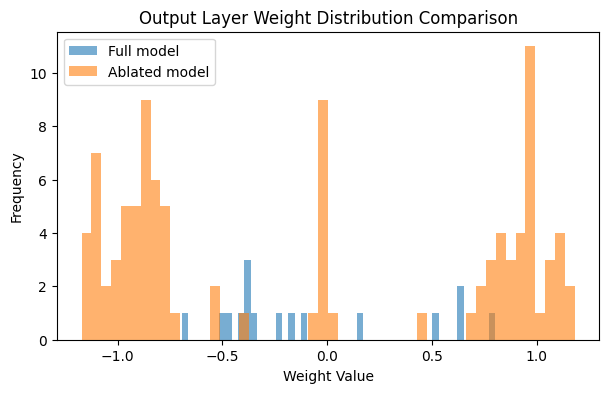

In [ ]:
### Compare Output Layer Weights Between Models

def get_output_weights(model):
    layer = model.get_layer("output")
    W, b = layer.get_weights()   # W shape: (hidden_dim or embed_dim, 1)
    return W.squeeze(), b

def compare_output_weights(model_full, model_ablated):
    W1, _ = get_output_weights(model_full)
    W2, _ = get_output_weights(model_ablated)

    plt.figure(figsize=(7,4))
    plt.hist(W1, bins=50, alpha=0.6, label="Full model")
    plt.hist(W2, bins=50, alpha=0.6, label="Ablated model")
    plt.legend()
    plt.title("Output Layer Weight Distribution Comparison")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.show()

compare_output_weights(model_dense, model_dense_abl)


In [ ]:
### Word‑Level Sentiment Contribution

def word_sentiment_score(word, tokenizer, model):
    idx = tokenizer.word_index.get(word)
    if idx is None:
        return None

    embedding_matrix = model.get_layer("embedding").get_weights()[0]
    emb = embedding_matrix[idx] # Shape (EMBED_SIZE,)

    # Get weights and biases for the intermediate dense layer ('dense_hidden')
    W_hidden, b_hidden = model.get_layer("dense_hidden").get_weights() # W_hidden shape (EMBED_SIZE, 16), b_hidden shape (16,)

    # Calculate the output of the dense_hidden layer for this single word embedding
    # np.dot(emb, W_hidden) will result in a (16,) vector after dot product
    hidden_output = np.dot(emb, W_hidden) + b_hidden
    # Apply ReLU activation and convert to numpy for subsequent np.dot
    hidden_output = tf.keras.activations.relu(hidden_output).numpy()

    # Get weights and biases for the final output layer
    W_output, b_output = get_output_weights(model) # W_output shape (16,), b_output shape (1,)

    # Now calculate logit using the hidden_output and final layer weights
    logit = np.dot(hidden_output, W_output) + b_output
    prob = tf.sigmoid(logit).numpy()

    return prob.item() # Use .item() to explicitly get the scalar value

words_to_test = ["good", "bad", "terrible", "amazing", "boring"]
for w in words_to_test:
    print(f"{w:10s} \u2192 {word_sentiment_score(w, t, model_dense):.4f}")


good       → 1.0000
bad        → 0.0000
terrible   → 0.0000
amazing    → 1.0000
boring     → 0.0000


In [ ]:
### Compare Word Scores Between Models

def word_sentiment_score_robust(word, tokenizer, model):
    idx = tokenizer.word_index.get(word)
    if idx is None:
        return None

    embedding_matrix = model.get_layer("embedding").get_weights()[0]
    emb = embedding_matrix[idx] # Shape (EMBED_SIZE,)

    # Check if the model has a 'dense_hidden' layer
    if "dense_hidden" in [layer.name for layer in model.layers]:
        # If it has, process through the hidden layer
        W_hidden, b_hidden = model.get_layer("dense_hidden").get_weights()
        hidden_output = np.dot(emb, W_hidden) + b_hidden
        hidden_output = tf.keras.activations.relu(hidden_output).numpy()
        # The input to the final output layer is the hidden_output
        input_to_output_layer = hidden_output
    else:
        # If no 'dense_hidden' layer, the input to the final output layer is the embedding itself
        input_to_output_layer = emb

    # Get weights and biases for the final output layer
    # Assuming get_output_weights is defined globally and returns W, b
    layer_output = model.get_layer("output")
    W_output, b_output = layer_output.get_weights()
    W_output = W_output.squeeze() # Ensure it's (input_dim,)

    # Calculate logit using the appropriate input
    logit = np.dot(input_to_output_layer, W_output) + b_output
    prob = tf.sigmoid(logit).numpy()

    return prob.item()

def compare_word_scores(words, tok, model1, model2, label1="full", label2="ablated"):
    rows = []
    for w in words:
        s1 = word_sentiment_score_robust(w, tok, model1)
        s2 = word_sentiment_score_robust(w, tok, model2)
        rows.append((w, s1, s2))

    df = pd.DataFrame(rows, columns=["word", label1, label2])
    print(df)

words = ["good", "bad", "great", "awful", "waste", "excellent", "horrible"]
compare_word_scores(words, t, model_dense, model_dense_abl)


        word  full  ablated
0       good   1.0      1.0
1        bad   0.0      0.0
2      great   1.0      1.0
3      awful   0.0      0.0
4      waste   0.0      0.0
5  excellent   1.0      1.0
6   horrible   0.0      0.0


#### c) Word embedding-enriched algorithms: Dense model with GloVe embeddings

To evaluate the impact of pretrained word embeddings such as Word2Vec and GloVe, experiments were conducted using a simple pooling-based neural architecture. This model consists of an embedding layer followed by a global pooling operation and a shallow feed-forward classifier. The rationale for selecting this architecture is that it places minimal modeling capacity beyond the word representations themselves. As a result, the performance of the model is largely determined by the quality of the underlying word embeddings.

By avoiding complex sequence modeling components such as recurrent or gated architectures, this setup allows the contribution of pretrained embeddings to be observed more directly. In higher-capacity models, improvements in word representations may be partially obscured by the model’s ability to learn task-specific semantic patterns. In contrast, the chosen architecture provides a clearer and more interpretable assessment of how semantic information encoded in pretrained embeddings influences sentiment classification performance.

**Frozen GloVe**

In [ ]:
glove_embeddings_index = {}

with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        glove_embeddings_index[word] = vector

print("Loaded", len(glove_embeddings_index), "GloVe vectors")

Loaded 400000 GloVe vectors


In [ ]:
EMBED_SIZE = 100
EPOCHS=10
BATCH_SIZE=128
VOCAB_SIZE = len(t.word_index) + 1

In [ ]:
glove_embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_SIZE))

for word, index in t.word_index.items():
    if index >= VOCAB_SIZE:
        continue

    if word == '<PAD>':
        glove_embedding_matrix[index] = np.zeros(EMBED_SIZE)
    else:
        vector = glove_embeddings_index.get(word)
        if vector is not None:
            glove_embedding_matrix[index] = vector
        else:
            # <UNK> and missing words remain zero
            pass

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sentiment_dense_glove"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1000, 100)      │     8,940,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 16)             │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,941,633 (34.11 MB)

 Trainable params: 1,633 (6.38 KB)

 Non-trainable params: 8,940,000 (34.10 MB)

Epoch 1/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.5652 - loss: 0.6879 - val_accuracy: 0.6546 - val_loss: 0.6647
Epoch 2/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.6589 - loss: 0.6565 - val_accuracy: 0.6783 - val_loss: 0.6314
Epoch 3/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.6823 - loss: 0.6258 - val_accuracy: 0.6989 - val_loss: 0.6062
Epoch 4/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.7025 - loss: 0.6023 - val_accuracy: 0.7174 - val_loss: 0.5857
Epoch 5/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.7214 - loss: 0.5829 - val_accuracy: 0.7323 - val_loss: 0.5689


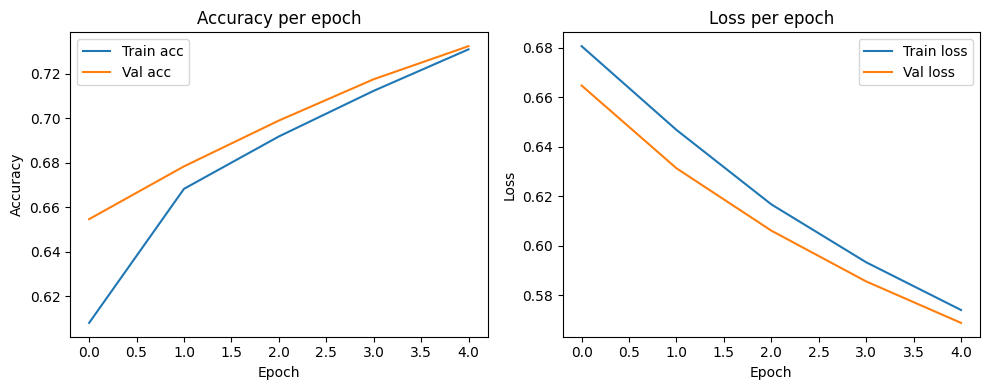

Test loss: 0.5661 | Test accuracy: 0.7370
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step

Classification report:
              precision    recall  f1-score   support

    negative       0.73      0.75      0.74      7490
    positive       0.74      0.73      0.73      7510

    accuracy                           0.74     15000
   macro avg       0.74      0.74      0.74     15000
weighted avg       0.74      0.74      0.74     15000


Confusion matrix:
 [[5586 1904]
 [2041 5469]]


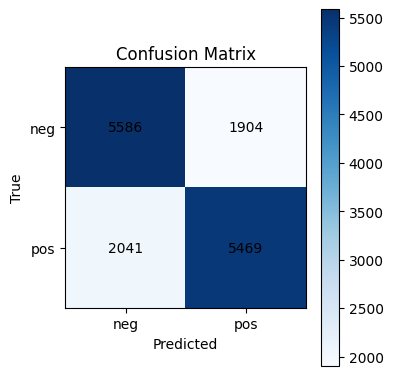

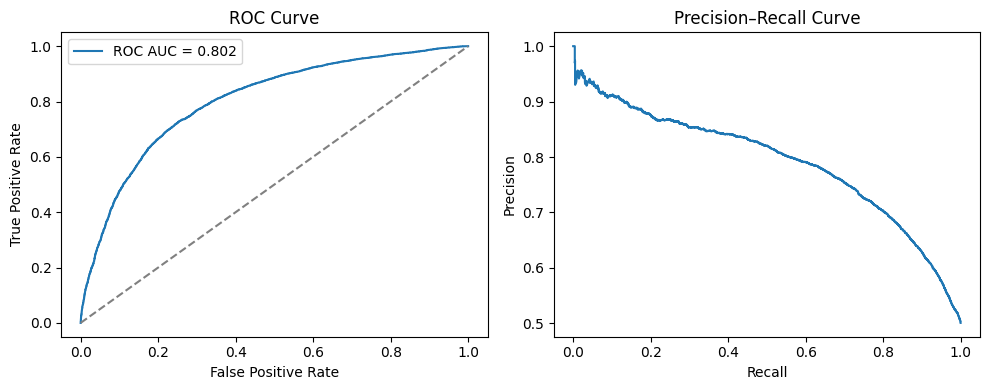

In [ ]:
K.clear_session()

model_dense_glove = Sequential(name="sentiment_dense_glove")

model_dense_glove.add(Embedding(
    VOCAB_SIZE,
    EMBED_SIZE,
    weights=[glove_embedding_matrix],
    input_shape=(MAX_SEQUENCE_LENGTH,),
    trainable=False,   # freeze for clean comparison
    name="embedding"
))

model_dense_glove.add(GlobalAveragePooling1D(name="avg_pool"))

model_dense_glove.add(Dense(16, activation='relu', name="dense_hidden"))

model_dense_glove.add(Dense(1, activation='sigmoid', name="output"))

model_dense_glove.summary()

# Optimizer
dense_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

artifacts_dense_glove = run_binary_pipeline(
    model_dense_glove,
    X_train, y_train, X_test, y_test,
    epochs=5,
    optimizer=dense_optimizer,
    batch_size=128,
    threshold=0.5,
    plot_curves=True,
    callbacks=[early_stopping_callback]
)


In [ ]:
print(t.word_index['good'])
print(glove_embedding_matrix[t.word_index['good']][:10])

51
[-0.030769    0.11993     0.53908998 -0.43696001 -0.73936999 -0.15345
  0.081126   -0.38558999 -0.68796998 -0.41632   ]


**Trainable GloVe**

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sentiment_dense_glove"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1000, 100)      │     8,940,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 16)             │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,941,633 (34.11 MB)

 Trainable params: 8,941,633 (34.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 79s 315ms/step - accuracy: 0.6356 - loss: 0.6921 - val_accuracy: 0.5151 - val_loss: 0.6790
Epoch 2/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 84s 322ms/step - accuracy: 0.5635 - loss: 0.6766 - val_accuracy: 0.5457 - val_loss: 0.6610
Epoch 3/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 79s 318ms/step - accuracy: 0.6828 - loss: 0.6034 - val_accuracy: 0.6937 - val_loss: 0.5517
Epoch 4/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 78s 314ms/step - accuracy: 0.7427 - loss: 0.5166 - val_accuracy: 0.8180 - val_loss: 0.4438
Epoch 5/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 79s 319ms/step - accuracy: 0.8104 - loss: 0.4317 - val_accuracy: 0.8369 - val_loss: 0.3993


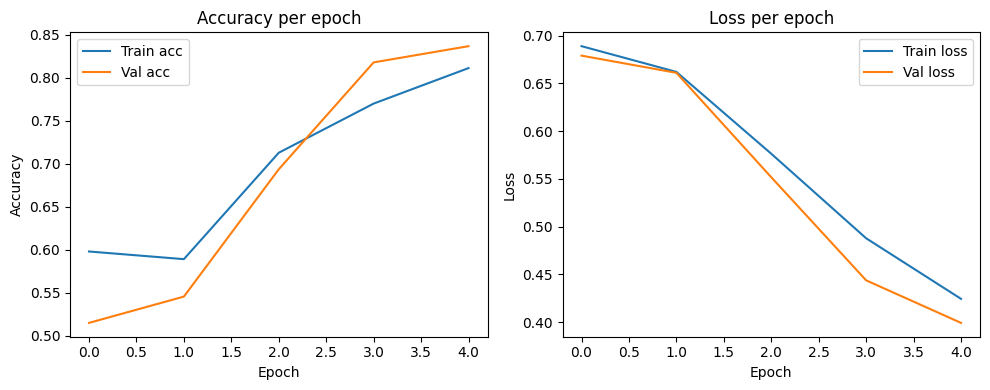

Test loss: 0.3932 | Test accuracy: 0.8376
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step

Classification report:
              precision    recall  f1-score   support

    negative       0.91      0.75      0.82      7490
    positive       0.79      0.92      0.85      7510

    accuracy                           0.84     15000
   macro avg       0.85      0.84      0.84     15000
weighted avg       0.85      0.84      0.84     15000


Confusion matrix:
 [[5626 1864]
 [ 572 6938]]


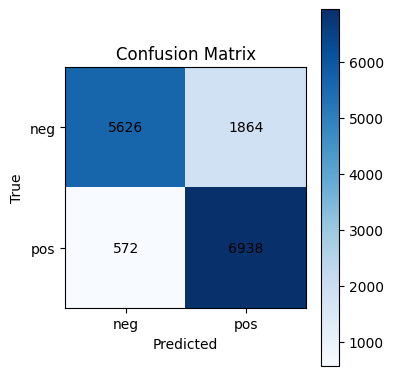

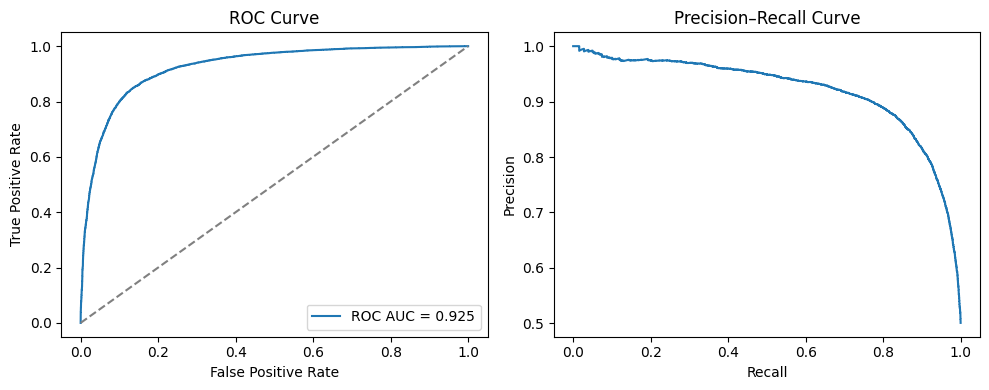

In [ ]:
K.clear_session()

model_dense_glove = Sequential(name="sentiment_dense_glove")

model_dense_glove.add(Embedding(
    VOCAB_SIZE,
    EMBED_SIZE,
    weights=[glove_embedding_matrix],
    input_shape=(MAX_SEQUENCE_LENGTH,),
    trainable=True,   # fine-tune the embeddings
    name="embedding"
))

model_dense_glove.add(GlobalAveragePooling1D(name="avg_pool"))

model_dense_glove.add(Dense(16, activation='relu', name="dense_hidden"))

model_dense_glove.add(Dense(1, activation='sigmoid', name="output"))

model_dense_glove.summary()

# Optimizer
dense_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

artifacts_dense_glove = run_binary_pipeline(
    model_dense_glove,
    X_train, y_train, X_test, y_test,
    epochs=5,
    optimizer=dense_optimizer,
    batch_size=128,
    threshold=0.5,
    plot_curves=True,
    callbacks=[early_stopping_callback]
)

### 2.3. Convolutional Neural Network (CNN)

Convolutional Neural Networks or CNNs are the work-horse of the deep learning world. They have, in some sense, brought deep learning research into mainstream discussions. The advancements in the image classification world has left even humans behind.

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

Since textual data is a sequence of words, we utilize 1D convolutions to scan through the sentences. The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

In [ ]:
MAX_SEQUENCE_LENGTH = 1000
EMBED_SIZE = 300

Prone to overfitting after only a few epochs --> early stopping callback
CNN filters can over-specialize, have many parameters --> Dropout improves robustness of learned n-gram features
Dropout can be added after convolution + pooling, or before final dense layer.

Where dropout is added (justification)

After each pooling block → regularizes learned n-gram features

Before the large dense layer → prevents heavy overfitting

Not on the embedding layer → preserves semantic structure

Dropout was applied after convolutional pooling layers and before the final dense layer to reduce overfitting. Dropout was not applied to the embedding layer to preserve semantic representations. Early stopping was used in combination with dropout to further improve generalization.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sentiment_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1000, 300)      │    26,820,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1000, 128)      │       153,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 500, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 250, 32)        │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 125, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 125, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,024,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,039,297 (106.96 MB)

 Trainable params: 28,039,297 (106.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 47s 180ms/step - accuracy: 0.6719 - loss: 0.6106 - val_accuracy: 0.8957 - val_loss: 0.2566
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 44s 176ms/step - accuracy: 0.9149 - loss: 0.2205 - val_accuracy: 0.8251 - val_loss: 0.6127
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 43s 176ms/step - accuracy: 0.9601 - loss: 0.1121 - val_accuracy: 0.8794 - val_loss: 0.3587


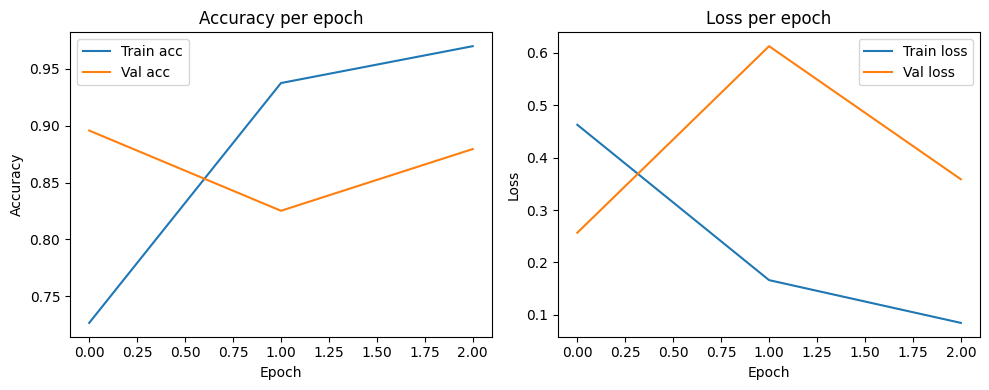

Test loss: 0.2533 | Test accuracy: 0.8966
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

Classification report:
              precision    recall  f1-score   support

    negative       0.94      0.85      0.89      7490
    positive       0.86      0.95      0.90      7510

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000


Confusion matrix:
 [[6341 1149]
 [ 402 7108]]


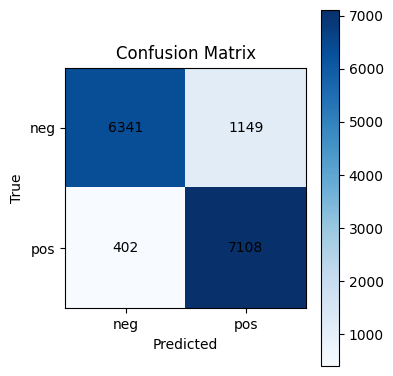

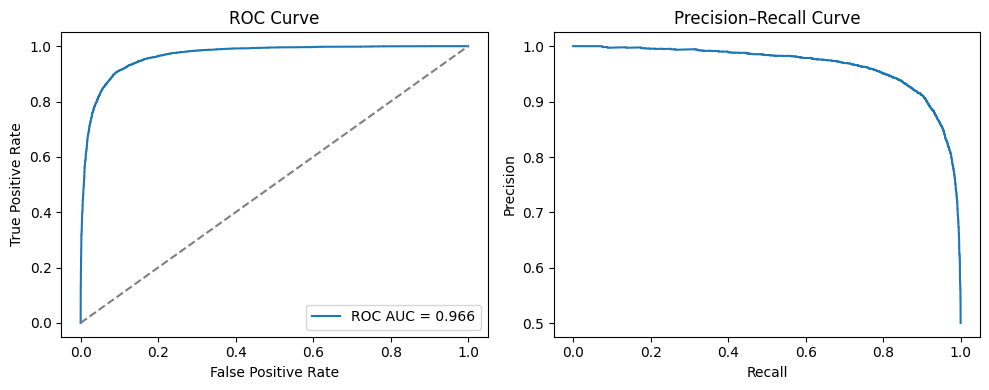

In [ ]:
import tensorflow as tf
K.clear_session()

# create the model
model_cnn = Sequential(name='sentiment_cnn_model')

model_cnn.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_shape=(MAX_SEQUENCE_LENGTH,),name="embedding"))
model_cnn.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu',name="conv1d"))
model_cnn.add(MaxPooling1D(pool_size=2,name="max_pooling1d"))
model_cnn.add(Dropout(0.3, name="dropout_1"))
model_cnn.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu',name="conv1d_1"))
model_cnn.add(MaxPooling1D(pool_size=2,name="max_pooling1d_1"))
model_cnn.add(Dropout(0.3, name="dropout_2"))
model_cnn.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu',name="conv1d_2"))
model_cnn.add(MaxPooling1D(pool_size=2,name="max_pooling1d_2"))
model_cnn.add(Dropout(0.3, name="dropout_3"))
model_cnn.add(Flatten(name="flatten"))
model_cnn.add(Dense(256, activation='relu',name="dense"))
model_cnn.add(Dropout(0.5, name="dropout_dense"))
model_cnn.add(Dense(1, activation='sigmoid',name="dense_1"))
model_cnn.summary()

# Create a new optimizer instance
cnn_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Define Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=2,          # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

artifacts_cnn = run_binary_pipeline(
    model_cnn,
    X_train, y_train, X_test, y_test,
    epochs=10, # Increased epochs as early stopping will handle when to stop
    batch_size=128,
    threshold=0.5,          # adjust later if needed
    plot_curves=True,
    optimizer=cnn_optimizer, # Pass the new optimizer instance to the pipeline
    callbacks=[early_stopping_callback] # Pass the early stopping callback
)


### 2.4. Recurrent Neural Networks (RNN)


#### a) Vanilla RNN

Overfitting, big difference training and test loss after few epochs.
However, careful with dropout. RNNs are sensitive to noise

Too much dropout hurts temporal learning

Recommended:

dropout = 0.1–0.3

Avoid stacking multiple dropout layers

In [ ]:
MAX_SEQUENCE_LENGTH = 1000
EMBED_SIZE = 8
EPOCHS = 8
BATCH_SIZE = 128

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sentiment_rnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1000, 8)        │       715,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 717,057 (2.74 MB)

 Trainable params: 717,057 (2.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
247/247 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.7421 - loss: 0.6762 - val_accuracy: 0.7466 - val_loss: 0.5463
Epoch 2/8
247/247 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.7820 - loss: 0.4655 - val_accuracy: 0.8509 - val_loss: 0.3497
Epoch 3/8
247/247 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.8851 - loss: 0.2833 - val_accuracy: 0.8631 - val_loss: 0.3416
Epoch 4/8
247/247 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.9218 - loss: 0.2047 - val_accuracy: 0.8523 - val_loss: 0.3679
Epoch 5/8
247/247 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - accuracy: 0.9474 - loss: 0.1481 - val_accuracy: 0.8611 - val_loss: 0.4023


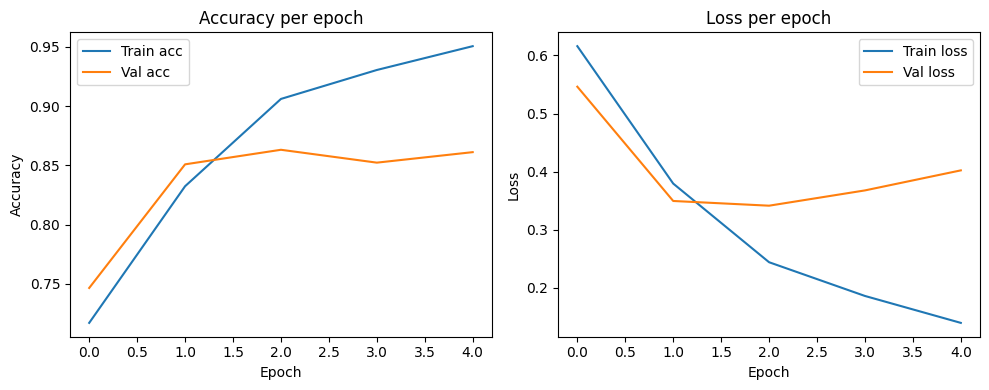

Test loss: 0.3237 | Test accuracy: 0.8721
469/469 ━━━━━━━━━━━━━━━━━━━━ 169s 360ms/step

Classification report:
              precision    recall  f1-score   support

    negative       0.89      0.84      0.87      7490
    positive       0.85      0.90      0.88      7510

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000


Confusion matrix:
 [[6322 1168]
 [ 751 6759]]


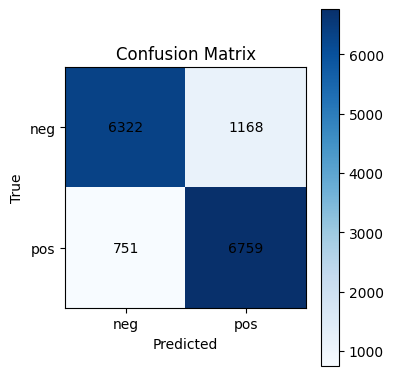

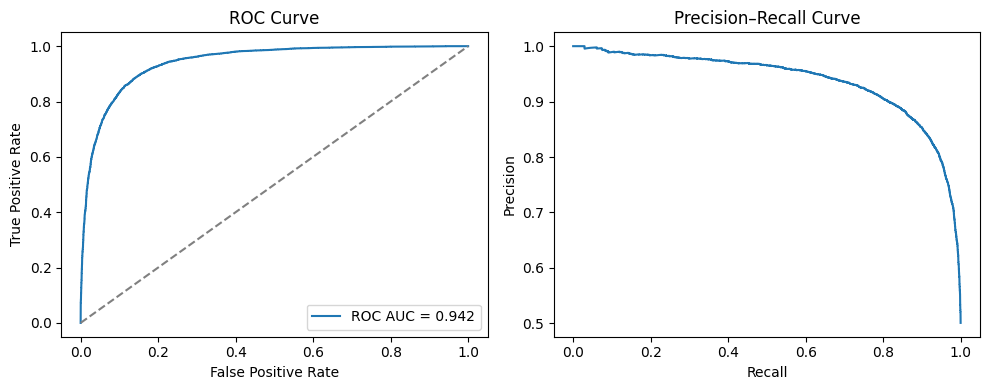

In [ ]:
from tensorflow.keras.layers import SimpleRNN, Dropout
from tensorflow.keras import backend as K

K.clear_session()

model_rnn = Sequential(name="sentiment_rnn_model")

model_rnn.add(Embedding(
    VOCAB_SIZE,
    EMBED_SIZE,
    input_shape=(MAX_SEQUENCE_LENGTH,),
    name="embedding"
))

# Vanilla RNN with input dropout
model_rnn.add(SimpleRNN(
    32,
    activation="tanh",
    dropout=0.2,           # input dropout
    recurrent_dropout=0.0, # keep recurrent connections stable
    name="simple_rnn"
))

model_rnn.add(Dense(16, activation="relu", name="dense_hidden"))
model_rnn.add(Dense(1, activation="sigmoid", name="output"))

model_rnn.summary()

# Optimizer
rnn_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

artifacts_rnn = run_binary_pipeline(
    model_rnn,
    X_train, y_train, X_test, y_test,
    epochs=EPOCHS,
    optimizer=rnn_optimizer,
    batch_size=BATCH_SIZE,
    threshold=0.5,
    plot_curves=True,
    callbacks=[early_stopping_callback]
)

#### b) RNN with LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding

In [ ]:
MAX_SEQUENCE_LENGTH = 1000
EMBED_SIZE = 8
EPOCHS = 8
BATCH_SIZE = 128

In [ ]:
from tensorflow.keras.layers import SimpleRNN
K.clear_session()

model_lstm = Sequential(name="sentiment_lstm_model")

model_lstm.add(Embedding(
    VOCAB_SIZE,
    EMBED_SIZE,
    input_shape=(MAX_SEQUENCE_LENGTH,),
    name="embedding"
))

# LSTM RNN layer
model_lstm.add(LSTM(16, dropout=0.5, recurrent_dropout=0.5))

model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

# Optimizer
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Define Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=2,          # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

artifacts_lstm = run_binary_pipeline(
    model_lstm,
    X_train, y_train, X_test, y_test,
    epochs=EPOCHS,
    optimizer=lstm_optimizer,
    batch_size=BATCH_SIZE,
    threshold=0.5,
    plot_curves=True,
    callbacks=[early_stopping_callback] # Pass the early stopping callback
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sentiment_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1000, 8)        │       715,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 716,817 (2.73 MB)

 Trainable params: 716,817 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
247/247 ━━━━━━━━━━━━━━━━━━━━ 842s 3s/step - accuracy: 0.7481 - loss: 0.6724 - val_accuracy: 0.7700 - val_loss: 0.5140
Epoch 2/8
247/247 ━━━━━━━━━━━━━━━━━━━━ 841s 3s/step - accuracy: 0.7713 - loss: 0.4991 - val_accuracy: 0.8011 - val_loss: 0.4377
Epoch 3/8
247/247 ━━━━━━━━━━━━━━━━━━━━ 855s 3s/step - accuracy: 0.8281 - loss: 0.4088 - val_accuracy: 0.8080 - val_loss: 0.4265
Epoch 4/8
 48/247 ━━━━━━━━━━━━━━━━━━━━ 11:12 3s/step - accuracy: 0.8490 - loss: 0.3662

#### c) RNN with GRU

Aggressive dropout limited the ability of recurrent models to retain long-range dependencies.

In [ ]:
from tensorflow.keras.layers import GRU
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential

K.clear_session()

model_gru = Sequential(name="sentiment_gru_model")

model_gru.add(Embedding(
    VOCAB_SIZE,
    EMBED_SIZE,
    input_shape=(MAX_SEQUENCE_LENGTH,),
    name="embedding"
))

# GRU RNN layer (matched to LSTM setup)
model_gru.add(GRU(
    16,
    dropout=0.5,
    recurrent_dropout=0.5,
    name="gru"
))

model_gru.add(Dense(1, activation='sigmoid', name="output"))

model_gru.summary()

# Optimizer
gru_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

artifacts_gru = run_binary_pipeline(
    model_gru,
    X_train, y_train, X_test, y_test,
    epochs=EPOCHS,
    optimizer=gru_optimizer,
    batch_size=BATCH_SIZE,
    threshold=0.5,
    plot_curves=True,
    callbacks=[early_stopping_callback]
)


### 2.5. Transformer Encoder Model

In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

To design the transformer we will define our own classes (or subclasses) using the Keras <font color=purple>Layer class</font>

* One of the central abstractions in Keras is the [Layer class](https://keras.io/guides/making_new_layers_and_models_via_subclassing/).

* A layer encapsulates both a state (the layer's "weights") and a transformation from inputs to outputs (a "call", the layer's forward pass).

**Implement a Transformer block as a layer**

In [ ]:
from tensorflow.keras import layers
import tensorflow.keras as keras

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

**Implement TWO embedding layers**

Two seperate embedding layers, one for tokens, one for token index (positions).

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

**Create classifier model using transformer layer**

Transformer layer outputs one vector for each time step of our input sequence.
Here, we take the mean across all time steps and
use a feed forward network on top of it to classify text.

In [1]:
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300
EPOCHS=5
BATCH_SIZE=128

#embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = TokenAndPositionEmbedding(MAX_SEQUENCE_LENGTH, VOCAB_SIZE, EMBED_SIZE)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)
x = transformer_block(x, training = X_train)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

# Optimizer
transformer_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

artifacts_transformer = run_binary_pipeline(
    model,
    X_train, y_train, X_test, y_test,
    epochs=5,
    optimizer=transformer_optimizer,
    batch_size=128,
    threshold=0.5,
    plot_curves=True,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    callbacks=[early_stopping_callback]
)

NameError: name 't' is not defined

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

NameError: name 'model' is not defined